## Launching

Using Spark 1.4 and Python 3.4. The way of launching the ipython notebook has changed

    IPYTHON=1 IPYTHON_OPTS=notebook PYSPARK_PYTHON=python3 pyspark

In [1]:
import os, sys

In [27]:
from pyspark.sql import SQLContext, Row
import datetime
from collections import namedtuple
import numpy as np
import pandas as pd

Create the SQLContext

In [3]:
sql = SQLContext(sc)

### Create different "classes" for parsing the input

Each row contains the (already computed) scenario values for each date and risk factor:

    Row = DAY x RiskFactor x NeutralScenario x Scenarios

Ideally the rows would be parsed like this, but because custom row aggregation is not fully supported

In [36]:
RFScenario = namedtuple('RFScenario', ('rf', 'date', 'neutral', 'scenarios'))

and because the number of scenarios is fixed, each scenario is a column

In [6]:
def construct_scenarios_type(number_scenarios=250, name = 'Scenarios'):
    names = ['rf', 'date', 'neutral']
    scenario_cols = ["s%d"%x for x in range(1,number_scenarios+1)]
    names.extend(scenario_cols)
    Scenarios = namedtuple('Scenarios', names)
    return Scenarios, scenario_cols

Scenarios, scenario_cols = construct_scenarios_type()

and we can parse the rows of the csv file accordingly

In [30]:
DATA_DIR = os.path.join(os.pardir, 'data')
csv_filename = os.path.join(DATA_DIR, "scenarios2.csv")
pd.read_csv(csv_filename, header=None).head()


,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,RF1,2015-04-14,35.03,34.678659,35.193093,35.611624,34.920900,35.275753,34.885387,34.794800,...,35.445356,34.829611,35.514069,35.372834,35.343582,34.828644,34.824178,34.774605,34.879511,34.856106
1,RF1,2015-04-15,35.20,35.359100,35.767287,35.093559,35.439729,35.058909,34.970520,34.606949,...,35.004487,35.672156,35.534417,35.505887,35.003543,34.999186,34.950814,35.053176,35.030339,35.248848
2,RF1,2015-04-16,34.25,34.863274,34.135051,34.509031,34.097640,34.002225,33.610037,34.563266,...,34.760356,34.611395,34.580549,34.037870,34.033167,33.980956,34.091450,34.066796,34.302765,34.434559
3,RF1,2015-04-17,33.30,33.179576,33.571484,33.140390,33.040462,32.629955,33.628347,34.043960,...,33.678814,33.646469,33.077790,33.072865,33.018190,33.133906,33.108084,33.355289,33.493416,32.332506
4,RF1,2015-04-20,33.40,33.664591,33.244414,33.146995,32.746707,33.720002,34.124926,33.055073,...,33.737661,33.183387,33.178585,33.125281,33.238094,33.212921,33.453890,33.588511,32.456574,32.499345


In [31]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector, _convert_to_vector 
def parse(row):
    DATE_FMT = "%Y-%m-%d"
    row[0] = row[0]
    row[1] = datetime.datetime.strptime(row[1], DATE_FMT)
    for i in np.arange(2,len(row)):
        row[i] = float(row[i])
    return RFScenario(row[0], row[1], row[2], DenseVector(row[3:6]))


def parse_explicit(row):
    DATE_FMT = "%Y-%m-%d"
    row[0] = row[0]
    row[1] = datetime.datetime.strptime(row[1], DATE_FMT)
    for i in np.arange(2,len(row)):
        row[i] = float(row[i])
    return Scenarios(*row)

### Process the file in Spark

In [21]:
lines = sc.textFile(csv_filename)
parts = lines.map(lambda l: l.split(","))
rows = parts.map(parse)

In [22]:
rows_exp = parts.map(parse_explicit)
df_exp = sql.createDataFrame(rows_exp)

In [23]:
df_exp.head(1)

[Row(rf='RF1', date=datetime.datetime(2015, 4, 14, 0, 0), neutral=35.03, s1=34.67865912475935, s2=35.19309272805697, s3=35.61162381981636, s4=34.92090026310803, s5=35.2757534118607, s6=34.88538726175033, s7=34.7947997828024, s8=34.422262176432426, s9=35.32719209964416, s10=35.70279197608641, s11=34.70929644638722, s12=35.16468125943031, s13=34.7083308292015, s14=34.6909371576162, s15=34.24743006243561, s16=35.18043521116673, s17=35.26710783535421, s18=34.68646893255419, s19=35.42074885668956, s20=35.10073110319397, s21=34.62729258634153, s22=34.590238555794265, s23=35.12518904748294, s24=34.54164263329866, s25=34.780562034944296, s26=35.009313286776944, s27=35.19898478845906, s28=34.22306349493622, s29=35.58776307961069, s30=34.86817402539321, s31=34.904330793280025, s32=34.501576221982006, s33=34.908487404457446, s34=34.927195922549025, s35=35.26215239163238, s36=33.92269249584361, s37=34.30733618265355, s38=34.834677237655015, s39=34.62744354378543, s40=34.77382130417254, s41=34.7282

### Let's do some VaR aggregation

For each day, we want to aggregate scenarios from different risk factors, and then compute the Value at Risk per day.

In [38]:
def var(scenarios, level=99, neutral_scenario=0):
    pnls = scenarios - neutral_scenario
    return - np.percentile(pnls, 100-level, interpolation='linear')

In [39]:
scenario_dates = df_exp.groupBy('date').sum()
var_rdd = scenario_dates.map(lambda r: (r[0], r[1], float(var(np.array(r[2:]) - r[1]))))
df_var = sql.createDataFrame(var_rdd, schema=['date', 'neutral', 'var'])

<IPython.core.display.Javascript object>


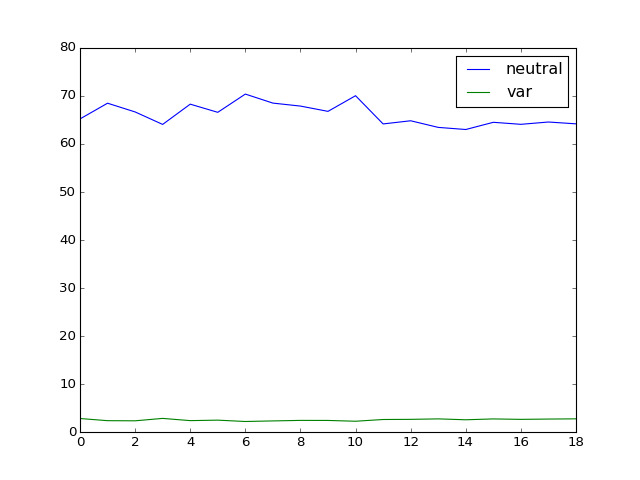

In [40]:
%matplotlib notebook
df_var.toPandas().plot()

## Slightly more complex case, with two portfolios

Define portfolios and put them into a Spark DataFrame

In [63]:
pf_rdd = sc.parallelize([('P1', 'RF1', 1.), ('P1', 'RF2', 2.), ('P2', 'RF1', 0.2), ('P2', 'RF2', -0.8)])
dfpf = sql.createDataFrame(pf_rdd, ['portfolio', 'rf', 'qty'])

In [64]:
dfpf.collect()

[Row(portfolio='P1', rf='RF1', qty=1.0),
 Row(portfolio='P1', rf='RF2', qty=2.0),
 Row(portfolio='P2', rf='RF1', qty=0.2),
 Row(portfolio='P2', rf='RF2', qty=-0.8)]

In [65]:
res = df_exp.join(dfpf, dfpf.rf == df_exp.rf)

In [66]:
res.head(1)

[Row(rf='RF1', date=datetime.datetime(2015, 4, 14, 0, 0), neutral=35.03, s1=34.67865912475935, s2=35.19309272805697, s3=35.61162381981636, s4=34.92090026310803, s5=35.2757534118607, s6=34.88538726175033, s7=34.7947997828024, s8=34.422262176432426, s9=35.32719209964416, s10=35.70279197608641, s11=34.70929644638722, s12=35.16468125943031, s13=34.7083308292015, s14=34.6909371576162, s15=34.24743006243561, s16=35.18043521116673, s17=35.26710783535421, s18=34.68646893255419, s19=35.42074885668956, s20=35.10073110319397, s21=34.62729258634153, s22=34.590238555794265, s23=35.12518904748294, s24=34.54164263329866, s25=34.780562034944296, s26=35.009313286776944, s27=35.19898478845906, s28=34.22306349493622, s29=35.58776307961069, s30=34.86817402539321, s31=34.904330793280025, s32=34.501576221982006, s33=34.908487404457446, s34=34.927195922549025, s35=35.26215239163238, s36=33.92269249584361, s37=34.30733618265355, s38=34.834677237655015, s39=34.62744354378543, s40=34.77382130417254, s41=34.7282

In [72]:
# scenario_dates = df_exp.groupBy('date').sum()
var_per_portfolio = res.groupBy('date', 'portfolio').sum()
# var_per_portfolio.toPandas().plot()
var_per_portfolio = var_per_portfolio.map(lambda r: (r[0], r[1], r[2], float(var(np.array(r[3:]) - r[2]))))
var_per_portfolio = sql.createDataFrame(var_per_portfolio, schema=['date', 'portfolio', 'neutral', 'var'])

In [82]:
%matplotlib notebook
df1 = var_per_portfolio.toPandas()
df2 = df1.set_index(['date', 'portfolio'])
# ['neutral'].plot(subplots=True)

In [95]:
df3 = df2.unstack(1) #['var'].plot(subplots=True)
df3

neutral              var          
portfolio       P1     P2        P1        P2
date                                         
2015-04-14   70.06  70.06  2.324244  2.324244
2015-04-15   70.40  70.40  2.268607  2.268607
2015-04-16   68.50  68.50  2.445955  2.445955
2015-04-17   66.60  66.60  2.559204  2.559204
2015-04-20   66.80  66.80  2.495879  2.495879
2015-04-21   66.68  66.68  2.417056  2.417056
2015-04-22   67.90  67.90  2.506571  2.506571
2015-04-23   68.30  68.30  2.456964  2.456964
2015-04-24   68.52  68.52  2.393792  2.393792
2015-04-27   65.22  65.22  2.911771  2.911771
2015-04-28   64.08  64.08  2.978352  2.978352
2015-04-29   63.46  63.46  2.872365  2.872365
2015-04-30   64.20  64.20  2.882594  2.882594
2015-05-01   64.58  64.58  2.834198  2.834198
2015-05-04   64.18  64.18  2.737028  2.737028
2015-05-05   63.02  63.02  2.676874  2.676874
2015-05-06   64.52  64.52  2.864054  2.864054
2015-05-07   64.10  64.10  2.766714  2.766714
2015-05-08   64.84  64.84  2.768306  2.768306

### Me trying to register python UDFs

In [ ]:
f = sql.udf.register("fadd", lambda x: (np.array(x[3]) * 3.1).tolist(), ArrayType(FloatType()))
fagg = sql.udf.register("fagg", lambda x,y: (np.array(x[3]) + np.array(y[3])).tolist(), ArrayType(FloatType()))

In [76]:
sql.registerDataFrameAsTable(df, 'scen')

In [128]:
sql.sql('select date, fadd(scenarios) from scen group by date').collect()

Py4JJavaError: An error occurred while calling o111.sql.
: org.apache.spark.sql.AnalysisException: expression 'pythonUDF' is neither present in the group by, nor is it an aggregate function. Add to group by or wrap in first() if you don't care which value you get.;
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$class.failAnalysis(CheckAnalysis.scala:38)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.failAnalysis(Analyzer.scala:42)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.org$apache$spark$sql$catalyst$analysis$CheckAnalysis$class$$anonfun$$checkValidAggregateExpression$1(CheckAnalysis.scala:95)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1$$anonfun$apply$4.apply(CheckAnalysis.scala:111)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1$$anonfun$apply$4.apply(CheckAnalysis.scala:111)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.apply(CheckAnalysis.scala:111)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.apply(CheckAnalysis.scala:50)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$foreachUp$1.apply(TreeNode.scala:97)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$foreachUp$1.apply(TreeNode.scala:97)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:97)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$class.checkAnalysis(CheckAnalysis.scala:50)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.checkAnalysis(Analyzer.scala:42)
	at org.apache.spark.sql.SQLContext$QueryExecution.assertAnalyzed(SQLContext.scala:920)
	at org.apache.spark.sql.DataFrame.<init>(DataFrame.scala:131)
	at org.apache.spark.sql.DataFrame$.apply(DataFrame.scala:51)
	at org.apache.spark.sql.SQLContext.sql(SQLContext.scala:744)
	at sun.reflect.GeneratedMethodAccessor53.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:744)
